## Fibonacci Classifier


Author: Brianna Gopaul


<h3>The fibonacci series is a sequence of numbers that increases as it sums up it's two subsequent values. For example, 1, 1, 2, 3 are numbers within the fibonacci series because 1 + 1 = 2 + 1 = 3. </h3>

<p><font size="3">Below we create a supervised model that classifies fibonacci sequences from non-fibonacci sequences in strawberryfields using The Quantum Machine Learning Toolbox. 



<img src="https://github.com/BriannaGopaul/strawberryfields/blob/patch-1/doc/gallery/FibonacciClassifier/Screen%20Shot%202018-07-27%20at%206.00.25%20PM%20copy.png?raw=true">

## Supervised Model Tutorial

In [ ]:
import strawberryfields as sf
from strawberryfields.ops import Dgate, Kgate, Sgate, Rgate, Vgate, Catstate, Zgate, BSgate
import tensorflow as tf
from qmlt.tf import CircuitLearner
from strawberryfields.ops import *
from qmlt.tf.helpers import make_param

Here we define the number of iterations we want our model to run through. 

In [ ]:
steps = 100

Now we create a circuit that contains trainable parameters. The lines proceeding it takes the shape of the input and runs the circuit. The tensorflow backend 'tf' is used and arguments eval, cutoff_dim and batch_size are defined. Depending on the backend used, different arguments will be required The fock backend can alternatively be used in this example.


The output of the circuit is measure using photon counting. If we measure zero photons in the first mode and two photons in the second mode, this output is defined as p0


In [ ]:
def circuit(X):
    kappa = make_param('kappa', constant=0.9)
    theta = make_param('theta', constant=2.25)


    eng, q = sf.Engine(2)

    with eng:
         Dgate(X[:, 0], X[:, 1]) | q[0]
         BSgate(theta=theta) | (q[0], q[1])
         Sgate(X[:, 0], X[:, 1]) | q[0]
         Sgate(X[:, 0], X[:, 1]) | q[1] 
         BSgate(theta=theta) | (q[0], q[1])
         Dgate(X[:, 0], X[:, 1]) | q[0]
         Kgate(kappa=kappa) | q[0]
         Kgate(kappa=kappa) | q[1]
    num_inputs = X.get_shape().as_list()[0]
    state = eng.run('tf', cutoff_dim=10, eval=False, batch_size=num_inputs)

    p0 = state.fock_prob([0, 2])
    p1 = state.fock_prob([2, 0])
    normalisation = p0 + p1 + 1e-10
    circuit_output = p1/normalisation
    return circuit_output

In machine learning, the loss function tells us how much error there is between the correct value and the output value. 
Mean Squared Error (MSE) minimizes the summation of all errors squared. We also load datasets that contain the fibonacci and non-fibonacci sequences.


In [ ]:
def myloss(circuit_output, targets):

    return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)
def outputs_to_predictions(circuit_output):
    return tf.round(circuit_output)

#download .csv files from strawberryfields/doc/gallery/fibonacci_classifier/datasets
import numpy as np
X_train = numpy.loadtxt('/Users/briannagopaul/Desktop/2X_train.csv', delimiter=',',dtype = float, skiprows=1)
Y_train = numpy.loadtxt('/Users/briannagopaul/Desktop/Y_train1.csv', delimiter=',',dtype = float, skiprows=1)
X_test = numpy.loadtxt('/Users/briannagopaul/Desktop/2X_test.csv', delimiter=',',dtype = float, skiprows=1)
Y_test = numpy.loadtxt('/Users/briannagopaul/Desktop/2Y_test.csv', delimiter=',',dtype = float, skiprows=1)
X_pred = numpy.loadtxt('/Users/briannagopaul/Desktop/2X_pred.csv', delimiter=',',dtype = float, skiprows=1)


Hyperparameters that define the task, optimizer and various other parameters listed in the QMLT docs are defined below. 
A learner is then fed the hyperparameters and data.


In [ ]:
hyperparams= {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'SGD',
               'init_learning_rate': 0.1,
               'print_log': True}

learner = CircuitLearner(hyperparams=hyperparams)
learner.train_circuit(X=X_train, Y=Y_train, steps=steps)

test_score = learner.score_circuit(X=X_test, Y=Y_test,outputs_to_predictions=outputs_to_predictions)
print("Accuracy on test set: ", test_score['accuracy'])
outcomes = learner.run_circuit(X=X_pred, outputs_to_predictions=outputs_to_predictions)
print("Predictions for new inputs: {}".format(outcomes['predictions']))  

## Observations

### Small Dataset vs Large Dataset

Here we fix the value of x_pred in each test and feed the model two different datasets to see the relationship between the model's accuracy and dataset size. The difficulty of x_pred increases every level. 

In [ ]:
X_pred_level1 = [[0.08, 0.13, 0.21, 0.34], [0.2, 0.3, 0.5, 0.8],[0.01, 0.01, 0.02, 0.03],[0.008, 0.013, 0.021, 0.034], [0.3, 0.5, 0.8, 0.13], [0.55, 0.64, 0.77, 0.21], [0.62, 0.93, 0.38, 0.23],[0.9, 0.8, 0.7, 0.6], [0.4, 0.6, 0.78, 0.77],[0.44, 0.96, 0.28, 0.33]]

In [ ]:
X_pred_level2 = [[0.34, 0.55, 0.89, 1.44], [0.003, 0.005, 0.008, 0.013], [0.3, 0.5, 0.8, 1.3], [0.08, 0.13, 0.21, 0.34], [0.5, 0.8, 1.3, 2.1], [0.413, 0.875, 0.066, 0.63], [0.3, 0.5, 0.7, 0.4], [0.3, 0.8, 0.12, 0.2], [0.4, 0.5, 0.7, 0.7], [0.7, 0.0, 0.6, 0.5]]

In [ ]:
X_pred_level3 = [[0.233, 0.377, 0.61, 0.987], [0.55, 0.89, 1.44, 2.33], [0.0013, 0.0021, 0.0034, 0.0055], [0.5, 0.8, 1.3, 2.1], [0.89, 1.44, 2.33, 3.77], [0.03, 0.05, 0.3, 0.13], [0.40, 0.34, 0.55, 0.89], [0.2, 0.45, 0.5, 0.8], [0.08, 0.13, 0.30, 0.34], [0.13, 0.21, 0.34, 0.80]]

### Small Dataset

In [ ]:
X_train = [[0.1, 0.1, 0.2, 0.3],[0.5, 0.8, 0.14, 0.21],[0.3, 0.4, 0.5, 0.8], [0.3, 0.6, 0.9, 0.13]]

Y_train = [1, 1, 0, 0]

X_test = [[0.5, 0.8, 0.13, 0.21], [0.21, 0.34, 0.55, 0.89], [0.7, 0.1, 0.879, 0.444], [0.20, 0.56, 0.909, 0.11]]

Y_test = [1, 1, 0, 0]

### Large Dataset

Check out the large dataset in strawberryfields/doc/gallery/fibonacci_classifier/datasets/...

In [ ]:
X_train = numpy.loadtxt('/Users/briannagopaul/Desktop/2X_train.csv', delimiter=',',dtype = float, skiprows=1)
Y_train = numpy.loadtxt('/Users/briannagopaul/Desktop/Y_train1.csv', delimiter=',',dtype = float, skiprows=1)
X_test = numpy.loadtxt('/Users/briannagopaul/Desktop/2X_test.csv', delimiter=',',dtype = float, skiprows=1)
Y_test = numpy.loadtxt('/Users/briannagopaul/Desktop/2Y_test.csv', delimiter=',',dtype = float, skiprows=1)
X_pred = numpy.loadtxt('/Users/briannagopaul/Desktop/2X_pred.csv', delimiter=',',dtype = float, skiprows=1)

### Data Generation 

In [ ]:
import random
import numpy as np
x=np.random.random(4)
np.set_printoptions(precision=2)
print(x)

In [ ]:
a = [1,1]
idx = 0
for i in range(30):
    a.append(a[idx] + a[idx+1])
    idx +=1
    print(a[-1]/100)      

## Results

### Level 1

In [ ]:
X_pred_level1 = [[0.08, 0.13, 0.21, 0.34], [0.2, 0.3, 0.5, 0.8],[0.01, 0.01, 0.02, 0.03],[0.008, 0.013, 0.021, 0.034], [0.3, 0.5, 0.8, 0.13], [0.55, 0.64, 0.77, 0.21], [0.62, 0.93, 0.38, 0.23],[0.9, 0.8, 0.7, 0.6], [0.4, 0.6, 0.78, 0.77],[0.44, 0.96, 0.28, 0.33]]

Level 1 is the easiest classification task. To challenge the model, the non-fibonacci sequences are close in value to each other.

__Tasks Classified Correctly:__
<br>
Large Dataset: 20%
<br>
Small Dataset: 80%

### Level 2

In [ ]:
X_pred_level2 = [[0.34, 0.55, 0.89, 1.44], [0.003, 0.005, 0.008, 0.013], [0.3, 0.5, 0.8, 1.3], [0.08, 0.13, 0.21, 0.34], [0.5, 0.8, 1.3, 2.1], [0.413, 0.875, 0.066, 0.63], [0.3, 0.5, 0.7, 0.4], [0.3, 0.8, 0.12, 0.2], [0.4, 0.5, 0.7, 0.7], [0.7, 0.0, 0.6, 0.5]]

Level 2 challenges the model by testing it against unfamiliar fibonacci sequences. The non-fibonacci numbers also become closer in value. 

__Tasks Classified Correctly:__ 
<br>
Large Dataset: 40%
<br>
Small Dataset: 70%

### Level 3

In [ ]:
X_pred_level3 = [[0.233, 0.377, 0.61, 0.987], [0.55, 0.89, 1.44, 2.33], [0.0013, 0.0021, 0.0034, 0.0055], [0.5, 0.8, 1.3, 2.1], [0.89, 1.44, 2.33, 3.77], [0.03, 0.05, 0.3, 0.13], [0.40, 0.34, 0.55, 0.89], [0.2, 0.45, 0.5, 0.8], [0.08, 0.13, 0.30, 0.34], [0.13, 0.21, 0.34, 0.80]]

Level 3 is the most difficult test set. 
<br>
It contains number sequences that appear to follow the fibonacci pattern but are off by a small value. e.g. 0.13, 0.21, 0.34, 0.80

__Tasks Classified Correctly: __
<br>
Large Dataset: 70%
<br>
Small Dataset: 30%

The graph below illustrates the performance of the small dataset model and the large dataset model on each test set.

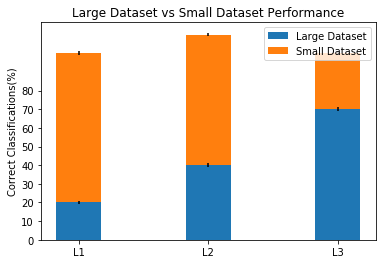

In [2]:
import numpy as np
import matplotlib.pyplot as plt


N = 3
B = (20, 40, 70)
A = (80, 70, 30)
BB = (1, 1, 1)
AA = (1, 1, 1)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, B, width, yerr=BB)
p2 = plt.bar(ind, A, width,
             bottom=B, yerr=AA)

plt.ylabel('Correct Classifications(%)')
plt.title('Large Dataset vs Small Dataset Performance')
plt.xticks(ind, ('L1', 'L2', 'L3'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Large Dataset', 'Small Dataset'))

plt.show()